# Song recommender project #

 Garcinuño Feliciano Angela <br>
 Huima Klaara <br>
 Massot Lucas 

In [16]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import axes3d

In [91]:
df = pd.read_csv("output.csv")
df['similar'] = df['similar'].apply(lambda x: x.split('/'))
df['artist_terms'] = df['artist_terms'].apply(lambda x: str(x).split('/'))
df['artist_terms_weights'] = df['artist_terms_weights'].apply(lambda x: str(x).split('/'))

l_max = df['loudness'].max()
l_min = df['loudness'].min()

t_max = df['tempo'].max()
t_min = df['tempo'].min()

df['tempo'] = (df['tempo'] - t_min)/(t_max - t_min)
df['loudness'] = (df['loudness'] - l_min)/(l_max - l_min)

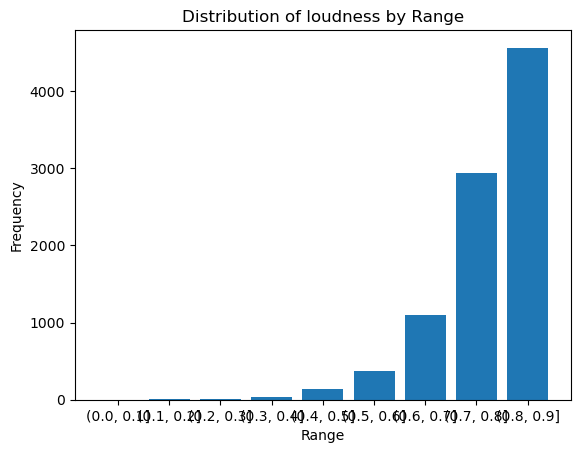

In [92]:
bins = [0+i/10 for i in range(10)]

# Create a new column with the bins
df['Binned'] = pd.cut(df['loudness'], bins=bins)

# Get value counts of the bins
value_counts = df['Binned'].value_counts().sort_index()

# Plot distribution
plt.bar(range(len(value_counts)), value_counts.values, tick_label=value_counts.index.astype(str))
plt.xlabel('Range')
plt.ylabel('Frequency')
plt.title('Distribution of loudness by Range')
plt.show()

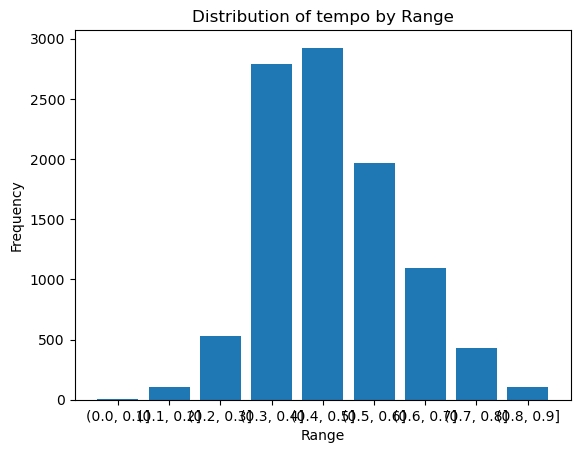

In [93]:
bins = [0+i/10 for i in range(10)]

# Create a new column with the bins
df['Binned'] = pd.cut(df['tempo'], bins=bins)

# Get value counts of the bins
value_counts = df['Binned'].value_counts().sort_index()

# Plot distribution
plt.bar(range(len(value_counts)), value_counts.values, tick_label=value_counts.index.astype(str))
plt.xlabel('Range')
plt.ylabel('Frequency')
plt.title('Distribution of tempo by Range')
plt.show()

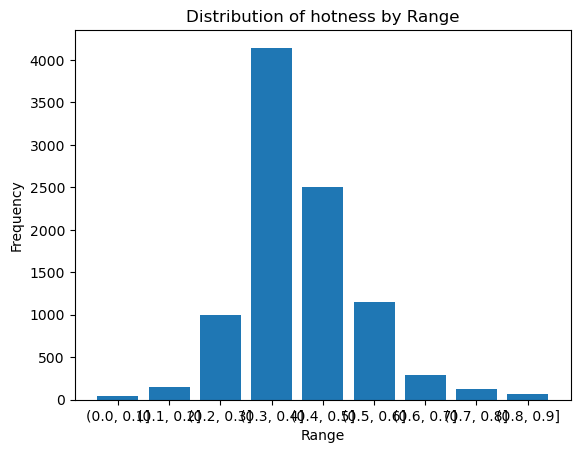

In [94]:
data = pd.read_csv("output.csv")
data['similar'] = data['similar'].apply(lambda x: x.split('/'))
data['artist_terms'] = data['artist_terms'].apply(lambda x: str(x).split('/'))
data['artist_terms_weights'] = data['artist_terms_weights'].apply(lambda x: str(x).split('/'))

l_max = data['loudness'].max()
l_min = data['loudness'].min()

t_max = data['tempo'].max()
t_min = data['tempo'].min()

data['tempo'] = (data['tempo'] - t_min)/(t_max - t_min)
data['loudness'] = (data['loudness'] - l_min)/(l_max - l_min)

In [29]:
def distance_by_terms(song1, song2, alphas = [1,1,1,1,1]):
    """
    song1, song2 : python native lists    format : [artist, title, album, similar, hottness, terms, terms-weights, loudness, tempo]
    alphas : python native list
    
    """
    
    alpha_hot, alpha_loud, alpha_tempo, alpha_similar, alpha_terms = alphas
    artist, title1, album1, similar1, hot1, terms1, weights1, loud1, tempo1 = song1
    artist2, title2, album2, similar2, hot2, terms2, weights2, loud2, tempo2 = song2
    

    hot = alpha_hot*abs(hot1-hot2)
    loud = alpha_loud*abs(loud1-loud2)
    tempo = alpha_tempo*abs(tempo1-tempo2)
    #similar artists
    similar_artists = alpha_similar*(1 - len([singer for singer in similar1 if singer in similar2])/100)
    # artist terms (and weights)
    shared_terms = [term for term in terms1 if (term in terms2 and term != '')]
    shared_weights1, shared_weights2 = [float(weights1[terms1.index(term)]) for term in shared_terms], [float(weights2[terms2.index(term)]) for term in shared_terms]
    artist_terms_weighted = alpha_terms*sum([0.5*(shared_weights1[i] + shared_weights2[i]) for i in range(len(shared_terms)) ])
    
    #print("hot: " + str(alpha_hot*abs(hot1-hot2) )+ " loud: " + str(alpha_loud*abs(loud1-loud2)) + " tempo: ", + str(alpha_tempo*abs(tempo1-tempo2) )+ "similar: " + 
    #str(alpha_similar*(1 - len([singer for singer in similar1 if singer in similar2])/100))+ "terms: " + str(alpha_terms*sum([0.5*(shared_weights1[i] + shared_weights2[i]) for i in range(len(shared_terms)) ])))
    
    return [hot,loud,tempo,similar_artists,artist_terms_weighted]

def distance(song1, song2, alphas = [1, 1, 1, 1, 1]):
    hot, loud, tempo, similar_artists, artist_terms = distance_by_terms(song1, song2, alphas)
    return hot+loud+tempo+similar_artists-artist_terms

In [20]:
def build_distances(input: list, df: pd.core.frame.DataFrame):
    N = len(input)
    M = len(df)
    distances = [[0 for i in range(N)] for j in range(M)]
    total_d = [0]*M
    for j in range(M):
        for i in range(N):
            distances[j][i] = distance(df.iloc[j], input[i])
        total_d[j] = sum(distances[j])

    return distances, total_d

In [21]:
def build_df(input: list, df: pd.core.frame.DataFrame):
    input_songs = [x.upper() for x in input]

    indexes = []
    result = []
    for i in range(len(df)):
        if str(df.iloc[i]['title']).upper() in input_songs:
            result.append(df.iloc[i])
            indexes.append(i)
    for i in indexes:
        df.drop(i, inplace=True)
    return result
    

In [22]:
def recommend(song_list: list, df: pd.core.frame.DataFrame):
    input = build_df(song_list, df)
    distances, total_d = build_distances(input, df)
    distances = pd.DataFrame(distances)
    results = np.argpartition(total_d, k)[:k]
    output = []
    d = []
    for i in results:
        output.append(df.iloc[i])
        d.append(total_d[i])
    output_df = pd.DataFrame(output)
    output_df = output_df[['artist_name', 'title','release']]
    output_df['total distance'] = d
    display(output_df)


In [23]:
# TEST
import random
print(data.iloc[0])

input = [str(data.iloc[j]['title']) for j in random.sample(range(len(data)), n)]
recommend(input, data.copy())

artist_name                                                        Casual
title                                                    I Didn't Mean To
release                                                       Fear Itself
similar                 [ARV4KO21187FB38008, ARWHM281187FB3D381, ARJGO...
hottness                                                         0.401998
artist_terms            [hip hop, underground rap, g funk, alternative...
artist_terms_weights    [1.0, 0.8979359555142553, 0.8842618474718359, ...
loudness                                                         0.774694
tempo                                                            0.350792
Name: 0, dtype: object


,artist_name,title,release,total distance
3190,Jackie Wilson,I'm Wanderin',The Jackie Wilson Genesis,-38.115763
3585,Deepest Blue,Is It A Sin,Euphoria: A Decade of Trance Anthems,-38.902298
6994,Jackie Wilson,Each Time (I Love You More),Lonely Teardrops,-38.042841
9011,Jackie Wilson,One Moment With You,Reet Petite,-37.555442
8293,Olive,You're Not Alone,Ministry of Sound Presents Chilled II 1991-2009,-37.477956
7992,Jackie Wilson,It's So Fine,Lonely Teardrops,-37.541466
4342,Jackie Wilson,If I Can't Have You,Lonely Teardrops,-36.657077
4480,Shapeshifters,Chime,Global Gathering 2008,-36.453344
8409,Jackie Wilson,Why Can't You Be Mine,Reet Petite,-35.945143
8051,Mungo Jerry,It's A Secret,The Best Of In The Summertime,-35.582571


In [ ]:
df.columns


Index(['artist_name', 'title', 'release', 'similar', 'hottness',
       'artist_terms', 'artist_terms_weights', 'loudness', 'tempo'],
      dtype='object')